## Evaluate different embedding models (for Information Retrieval) from:

https://www.sbert.net/docs/sentence_transformer/pretrained_models.html



In [ ]:
# import project from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# provide project root path
ProjectRoot = "/content/drive/MyDrive/UMich Capstone/NoteBooks/"
DatasetRoot = ProjectRoot + "Dataset/"

#### Dependencies

In [ ]:
try:
    import chromadb
except ImportError:
    !pip install chromadb

try:
    import sentence_transformers
except ImportError:
    !pip install -U sentence-transformers

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
import chromadb
from sentence_transformers import SentenceTransformer
# misc
import json
import regex as re
import numpy as np
import pandas as pd
# viz
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# loading full article from json file
with open(DatasetRoot + 'raw_knowledge.json', 'r') as f:
    raw_text_json = json.load(f)
raw_text_list = [text for _, text in raw_text_json.items()]
# unique id per doc
raw_text_ids = [idx for idx, _ in raw_text_json.items()]

In [ ]:
# load context-question train set which was created by doc2query
train_df = pd.read_csv(DatasetRoot + '/q_a_trainset.csv')

In [ ]:
# dataframe holding metrics for different embeddings
embeddings_metrics_df = pd.DataFrame(columns=['Embedding', 'Precision', 'Recall', 'MRR'])

In [ ]:
# calculate Retrieval Precision, Recall, MRR
def evaluate_retrieval(embed_model, retriever, eval_dataset, top_n=3):
    precision_at_k = []
    recall_at_k = []
    mrr = []

    for _, eval_data in eval_dataset.iterrows():

        # get query and raw paragraph ID from where question was generated.
        # This paragraph will be treated as ground truth doc
        raw_para_id = eval_data['raw_para_id']
        query = eval_data['question']

        # embed query into vector
        query_embedding = embed_model.encode(query).tolist()
        # search most relevant docs
        retrieved_docs = retriever.query(query_embeddings=query_embedding, n_results=top_n)
        doc_indices = [int(idx) for idx in retrieved_docs['ids'][0]]

        relevant_docs = set([raw_para_id])
        retrieved_docs = set(doc_indices)

        hits = relevant_docs & retrieved_docs
        '''
        if len(hits) > 0:

            print(f"raw para id: {raw_para_id} ...")
            print(f"fetch_id: {doc_indices} ...")
            print(f"question: {query} ...")
            print(f"\n")
        '''

        precision = len(hits) / len(retrieved_docs)
        recall = len(hits) / len(relevant_docs)

        precision_at_k.append(precision)
        recall_at_k.append(recall)

        reciprocal_rank = 0.0
        for rank, doc_index in enumerate(doc_indices, start=1):
            if doc_index in relevant_docs:
                reciprocal_rank = 1.0 / rank
                break
        mrr.append(reciprocal_rank)

    avg_precision = np.mean(precision_at_k)
    avg_recall = np.mean(recall_at_k)
    avg_mrr = np.mean(mrr)

    return avg_precision, avg_recall, avg_mrr

### Eval sentence-transformers/all-mpnet-base-v2 Embedding

https://huggingface.co/sentence-transformers/all-mpnet-base-v2

In [ ]:
# import embeddings
model_name = 'sentence-transformers/all-mpnet-base-v2'
st_allmpnetbase_model = SentenceTransformer(model_name)

raw_text_embeddings = [st_allmpnetbase_model.encode(text).tolist() for text in raw_text_list]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# setup Chroma in-memory
client = chromadb.Client()

Retriever_st_allmpnetbase = client.create_collection("knowledge-store-st_allmpnetbase")
# Add docs to the knowledge store
Retriever_st_allmpnetbase.add(
    embeddings = raw_text_embeddings,
    documents = raw_text_list,
    ids=raw_text_ids
)

In [ ]:
# calculate precision, recall, mrr
precision, recall, mrr = evaluate_retrieval(st_allmpnetbase_model, Retriever_st_allmpnetbase, train_df[['raw_para_id', 'question']])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, MRR: {mrr:.4f}")

# record results
new_row = pd.DataFrame({
    'Embedding': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'MRR': [mrr]
})
embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)


Precision: 0.2326, Recall: 0.6979, MRR: 0.5608


### Eval sentence-transformers/all-MiniLM-L6-v2 Embedding

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

Default embedding for ChromaDB https://docs.trychroma.com/guides/embeddings

In [ ]:
# import embeddings
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
st_allMiniLML6_model = SentenceTransformer(model_name)

raw_text_embeddings = [st_allMiniLML6_model.encode(text).tolist() for text in raw_text_list]

KeyboardInterrupt: 

In [ ]:
# setup Chroma in-memory
client = chromadb.Client()

Retriever_st_allMiniLML6 = client.create_collection("knowledge-store-st_allMiniLML6")
# Add docs to the knowledge store
Retriever_st_allMiniLML6.add(
    embeddings = raw_text_embeddings,
    documents = raw_text_list,
    ids=raw_text_ids
)

In [ ]:
# calculate precision, recall, mrr
precision, recall, mrr = evaluate_retrieval(st_allMiniLML6_model, Retriever_st_allMiniLML6, train_df[['raw_para_id', 'question']])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, MRR: {mrr:.4f}")

# record results
new_row = pd.DataFrame({
    'Embedding': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'MRR': [mrr]
})
embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)


Precision: 0.2431, Recall: 0.7292, MRR: 0.5660


### Eval sentence-transformers/average_word_embeddings_glove.840B.300d Embedding

https://huggingface.co/sentence-transformers/average_word_embeddings_glove.840B.300d

In [ ]:
# import embeddings
model_name = 'sentence-transformers/average_word_embeddings_glove.840B.300d'
st_embeddingsglove_model = SentenceTransformer(model_name)

raw_text_embeddings = [st_embeddingsglove_model.encode(text).tolist() for text in raw_text_list]

In [ ]:
# setup Chroma in-memory
client = chromadb.Client()

Retriever_st_embeddingsglove = client.create_collection("knowledge-store-st_embeddingsglove")
# Add docs to the knowledge store
Retriever_st_embeddingsglove.add(
    embeddings = raw_text_embeddings,
    documents = raw_text_list,
    ids=raw_text_ids
)

In [ ]:
# calculate precision, recall, mrr
precision, recall, mrr = evaluate_retrieval(st_embeddingsglove_model, Retriever_st_embeddingsglove, train_df[['raw_para_id', 'question']])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, MRR: {mrr:.4f}")

# record results
new_row = pd.DataFrame({
    'Embedding': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'MRR': [mrr]
})
embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)


Precision: 0.1285, Recall: 0.3854, MRR: 0.2917


### Eval sentence-transformers/multi-qa-mpnet-base-dot-v1 Embedding

In [ ]:
# import embeddings
model_name = 'sentence-transformers/multi-qa-mpnet-base-dot-v1'
st_multiqampnetbasedot_model = SentenceTransformer(model_name)

raw_text_embeddings = [st_multiqampnetbasedot_model.encode(text).tolist() for text in raw_text_list]

In [ ]:
# setup Chroma in-memory
client = chromadb.Client()

Retriever_st_multiqampnetbasedot = client.create_collection("knowledge-store-st_multiqampnetbasedot")
# Add docs to the knowledge store
Retriever_st_multiqampnetbasedot.add(
    embeddings = raw_text_embeddings,
    documents = raw_text_list,
    ids=raw_text_ids
)

In [ ]:
# calculate precision, recall, mrr
precision, recall, mrr = evaluate_retrieval(st_multiqampnetbasedot_model, Retriever_st_multiqampnetbasedot, train_df[['raw_para_id', 'question']])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, MRR: {mrr:.4f}")

# record results
new_row = pd.DataFrame({
    'Embedding': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'MRR': [mrr]
})
embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)


Precision: 0.2188, Recall: 0.6562, MRR: 0.5503


### Eval sentence-transformers/multi-qa-mpnet-base-cos-v1 Embedding

In [ ]:
# import embeddings
model_name = 'sentence-transformers/multi-qa-mpnet-base-cos-v1'
st_multiqampnetbasecos_model = SentenceTransformer(model_name)

raw_text_embeddings = [st_multiqampnetbasecos_model.encode(text).tolist() for text in raw_text_list]

In [ ]:
# setup Chroma in-memory
client = chromadb.Client()

Retriever_st_multiqampnetbasecos = client.create_collection("knowledge-store-st_multiqampnetbasecos")
# Add docs to the knowledge store
Retriever_st_multiqampnetbasecos.add(
    embeddings = raw_text_embeddings,
    documents = raw_text_list,
    ids=raw_text_ids
)

In [ ]:
# calculate precision, recall, mrr
precision, recall, mrr = evaluate_retrieval(st_multiqampnetbasecos_model, Retriever_st_multiqampnetbasecos, train_df[['raw_para_id', 'question']])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, MRR: {mrr:.4f}")

# record results
new_row = pd.DataFrame({
    'Embedding': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'MRR': [mrr]
})
embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)


Precision: 0.2396, Recall: 0.7188, MRR: 0.5990


### Eval sentence-transformers/all-distilroberta-v1 Embedding

In [ ]:
# import embeddings
model_name = "sentence-transformers/all-distilroberta-v1"
st_distilroberta_model = SentenceTransformer(model_name)

raw_text_embeddings = [st_distilroberta_model.encode(text).tolist() for text in raw_text_list]

In [ ]:
# setup Chroma in-memory
client = chromadb.Client()

Retriever_st_distilroberta = client.create_collection("knowledge-store-st_distilroberta")
# Add docs to the knowledge store
Retriever_st_distilroberta.add(
    embeddings = raw_text_embeddings,
    documents = raw_text_list,
    ids=raw_text_ids
)

In [ ]:
# calculate precision, recall, mrr
precision, recall, mrr = evaluate_retrieval(st_distilroberta_model, Retriever_st_distilroberta, train_df[['raw_para_id', 'question']])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, MRR: {mrr:.4f}")

# record results
new_row = pd.DataFrame({
    'Embedding': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'MRR': [mrr]
})
embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)


Precision: 0.2361, Recall: 0.7083, MRR: 0.5382


### Eval colbert-ir/colbertv2.0 Embedding

https://huggingface.co/colbert-ir/colbertv2.0

Default embedding for RAGatouille https://github.com/bclavie/RAGatouille

In [ ]:
# import embeddings
model_name = "colbert-ir/colbertv2.0"
colbertv2_model = SentenceTransformer(model_name)

raw_text_embeddings = [colbertv2_model.encode(text).tolist() for text in raw_text_list]

In [ ]:
# setup Chroma in-memory
client = chromadb.Client()

Retriever_colbertv2 = client.create_collection("knowledge-store-colbertv2")
# Add docs to the knowledge store
Retriever_colbertv2.add(
    embeddings = raw_text_embeddings,
    documents = raw_text_list,
    ids=raw_text_ids
)

In [ ]:
# calculate precision, recall, mrr
precision, recall, mrr = evaluate_retrieval(colbertv2_model, Retriever_colbertv2, train_df[['raw_para_id', 'question']])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, MRR: {mrr:.4f}")

# record results
new_row = pd.DataFrame({
    'Embedding': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'MRR': [mrr]
})
embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)


Precision: 0.2500, Recall: 0.7500, MRR: 0.5573


### Compare different embeddings based on Precision, Recall, MRR

In [ ]:
embeddings_metrics_df

,Embedding,Precision,Recall,MRR
0,sentence-transformers/all-mpnet-base-v2,0.232639,0.697917,0.560764
1,sentence-transformers/all-MiniLM-L6-v2,0.243056,0.729167,0.565972
2,sentence-transformers/average_word_embeddings_...,0.128472,0.385417,0.291667
3,sentence-transformers/multi-qa-mpnet-base-dot-v1,0.218750,0.656250,0.550347
4,sentence-transformers/multi-qa-mpnet-base-cos-v1,0.239583,0.718750,0.598958
5,sentence-transformers/all-distilroberta-v1,0.236111,0.708333,0.538194
6,colbert-ir/colbertv2.0,0.250000,0.750000,0.557292


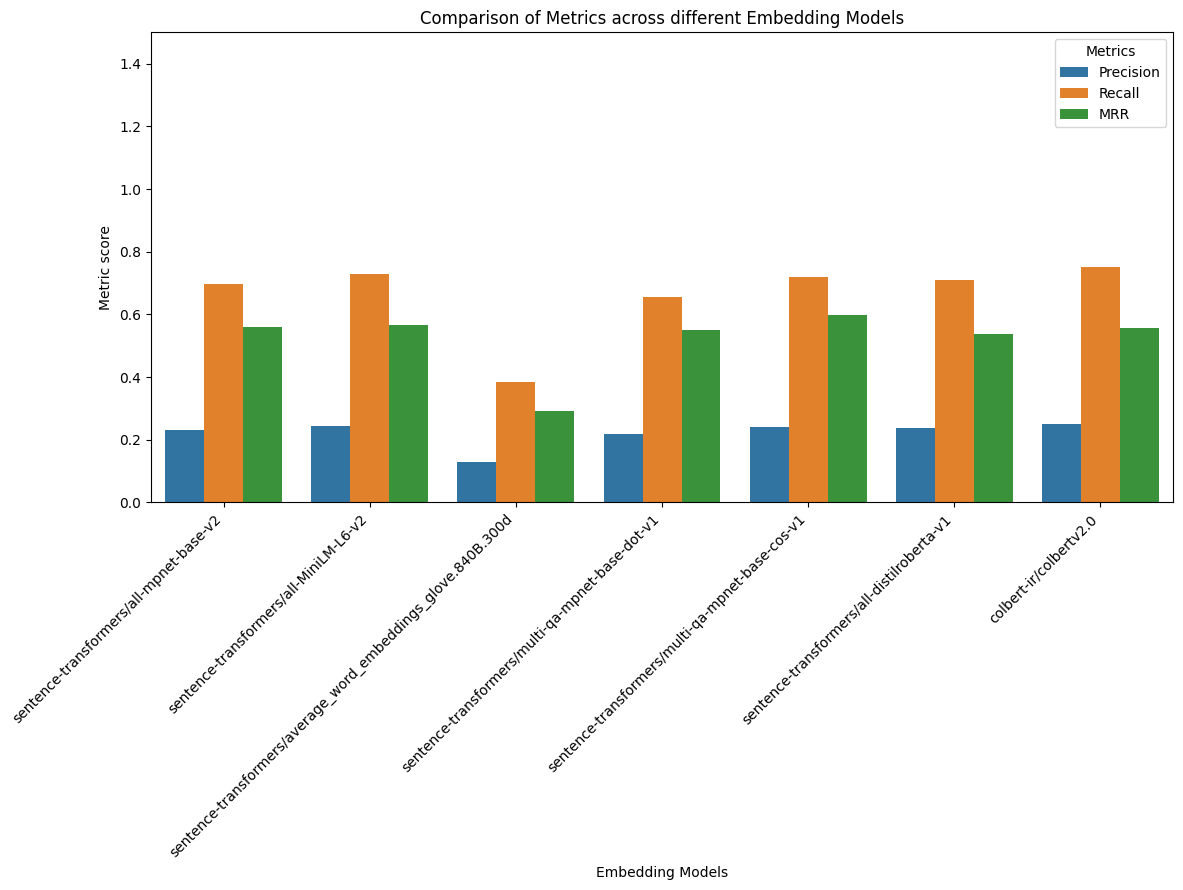

In [ ]:
# melt df to plot Precision, Recall, MRR
melted_df = embeddings_metrics_df.melt(id_vars='Embedding', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 9))
sns.barplot(data=melted_df, x='Embedding', y='Value', hue='Metric')
plt.title('Comparison of Metrics across different Embedding Models')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Embedding Models')
plt.ylabel('Metric score')
plt.ylim(0.0, 1.5)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()